In [1]:
# PDF印刷用
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 2
pdf_base = 'pdf-01-'

def create_pdf():
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.rcParams['figure.subplot.bottom'] = 0.15
    plt.rcParams['figure.subplot.left'] = 0.15
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

### 11.6  最適化関数

### ライブラリ・環境設定

#### ライブラリ導入

In [2]:
# 必要ライブラリ追加導入
!pip install japanize-matplotlib -qq
!pip install torchviz -qq
!pip install torchinfo -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 55.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#### ライブラリインポート

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
from tqdm.notebook import tqdm

#### 環境設定

In [4]:
np.set_printoptions(formatter={'float': '{:0.3f}'.format})
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings('ignore')

#### GPU存在チェック

In [5]:
# GPU存在チェック

# GPUが利用可能かどうかのチェック
device = torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

# 利用可能な場合は"cuda:0"が出力される
print(device)

cuda:0


### データ準備

#### データローダー構築

In [6]:
# データローダー構築
def get_data_loaders(batch_size=100, data_dir="./data"):
    """MNISTの訓練・テストデータをDataLoaderで返す"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_set = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    test_set  = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, test_loader

batch_size = 100
train_loader, test_loader = get_data_loaders(batch_size)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.7MB/s]


### モデル構築

#### モデル定義



In [7]:
class Net(nn.Module):
    """全結合1層のシンプルなNN（MNIST想定: 28*28 -> 100 -> 10）"""
    def __init__(self, n_input=28*28, n_hidden=100, n_output=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_output)
        )

    def forward(self, x):
        # (B, 1, 28, 28) -> (B, 784)
        x = torch.flatten(x, 1)
        return self.net(x)

#### 訓練用関数

In [8]:
# 学習用関数

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 勾配初期化
        optimizer.zero_grad()
        # 予測計算
        outputs = model(inputs)
        # 損失計算
        loss = criterion(outputs, labels)
        # 勾配(微分)計算
        loss.backward()
        # パラメータ更新
        optimizer.step()

        with torch.no_grad():
            preds = outputs.argmax(1)
            running_loss += loss.item() * labels.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

#### 検証用関数

In [9]:
# 検証用関数

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = outputs.argmax(1)

        running_loss += loss.item() * labels.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

#### 学習関数

In [10]:
def fit(*, net_class=Net, n_hidden=100, num_epochs=20, lr=0.01,
        batch_size=100, optimizer_class=optim.SGD,
        seed=42, data_dir="./data"):
    """
    引数（すべてキーワード専用）:
        net_class       : モデルクラス（例: Net, CustomCNNなど）
        n_hidden        : 隠れ層ノード数（Net使用時のみ）
        num_epochs      : 繰り返し数
        lr              : 学習率
        batch_size      : バッチサイズ
        optimizer_class : 最適化関数クラス (例: optim.SGD, optim.Adam)

    戻り値:
        model, history(np.ndarray: [epoch, train_loss, train_acc, val_loss, val_acc])
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    # DataLoader作成（バッチサイズ指定）
    train_loader, test_loader = get_data_loaders(batch_size=batch_size,
                                                 data_dir=data_dir)

    # モデル構築（引数対応）
    try:
        model = net_class(n_hidden=n_hidden).to(device)
    except TypeError:
        model = net_class().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=lr)

    history = []
    for epoch in tqdm(range(1, num_epochs + 1), desc="Training"):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion,
                                          optimizer)
        va_loss, va_acc = validate(model, test_loader, criterion)

        print(
            f"Epoch [{epoch}/{num_epochs}] "
            f"train_loss: {tr_loss:.5f}, train_acc: {tr_acc:.5f}, "
            f"val_loss: {va_loss:.5f}, val_acc: {va_acc:.5f}"
        )
        history.append([epoch, tr_loss, tr_acc, va_loss, va_acc])

    return model, np.array(history, dtype=float)

#### 学習(最適化関数間の比較)

In [11]:
# 学習(最適化関数間の比較)
from functools import partial
import torch.optim as optim

# オリジナル（SGD, momentumなし）
model1, history1 = fit(optimizer_class=optim.SGD, num_epochs=20, lr=0.01)

# Momentum（SGD + momentum=0.9）
model2, history2 = fit(optimizer_class=partial(optim.SGD, momentum=0.9),
                       num_epochs=20, lr=0.01)

# RMSProp
model3, history3 = fit(optimizer_class=optim.RMSprop, num_epochs=20, lr=0.001)

# Adam
model4, history4 = fit(optimizer_class=optim.Adam, num_epochs=20, lr=0.001)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 0.70944, train_acc: 0.82948, val_loss: 0.36484, val_acc: 0.90030
Epoch [2/20] train_loss: 0.34260, train_acc: 0.90292, val_loss: 0.30016, val_acc: 0.91420
Epoch [3/20] train_loss: 0.29471, train_acc: 0.91510, val_loss: 0.26729, val_acc: 0.92500
Epoch [4/20] train_loss: 0.26505, train_acc: 0.92348, val_loss: 0.24612, val_acc: 0.93000
Epoch [5/20] train_loss: 0.24184, train_acc: 0.93078, val_loss: 0.22569, val_acc: 0.93780
Epoch [6/20] train_loss: 0.22313, train_acc: 0.93635, val_loss: 0.21003, val_acc: 0.94170
Epoch [7/20] train_loss: 0.20713, train_acc: 0.94155, val_loss: 0.19760, val_acc: 0.94460
Epoch [8/20] train_loss: 0.19323, train_acc: 0.94583, val_loss: 0.18607, val_acc: 0.94630
Epoch [9/20] train_loss: 0.18111, train_acc: 0.94885, val_loss: 0.17638, val_acc: 0.95000
Epoch [10/20] train_loss: 0.17037, train_acc: 0.95200, val_loss: 0.16643, val_acc: 0.95260
Epoch [11/20] train_loss: 0.16080, train_acc: 0.95498, val_loss: 0.15776, val_acc: 0.95460
Epoch [1

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 0.33215, train_acc: 0.90405, val_loss: 0.17514, val_acc: 0.94960
Epoch [2/20] train_loss: 0.14666, train_acc: 0.95793, val_loss: 0.12074, val_acc: 0.96450
Epoch [3/20] train_loss: 0.10359, train_acc: 0.96918, val_loss: 0.09457, val_acc: 0.97210
Epoch [4/20] train_loss: 0.08030, train_acc: 0.97668, val_loss: 0.08678, val_acc: 0.97290
Epoch [5/20] train_loss: 0.06648, train_acc: 0.98023, val_loss: 0.07894, val_acc: 0.97700
Epoch [6/20] train_loss: 0.05529, train_acc: 0.98367, val_loss: 0.07344, val_acc: 0.97760
Epoch [7/20] train_loss: 0.04672, train_acc: 0.98700, val_loss: 0.07409, val_acc: 0.97780
Epoch [8/20] train_loss: 0.04049, train_acc: 0.98848, val_loss: 0.07131, val_acc: 0.97860
Epoch [9/20] train_loss: 0.03496, train_acc: 0.99032, val_loss: 0.07326, val_acc: 0.97840
Epoch [10/20] train_loss: 0.03040, train_acc: 0.99177, val_loss: 0.07067, val_acc: 0.97840
Epoch [11/20] train_loss: 0.02670, train_acc: 0.99352, val_loss: 0.07267, val_acc: 0.97770
Epoch [1

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 0.26075, train_acc: 0.92205, val_loss: 0.14752, val_acc: 0.95710
Epoch [2/20] train_loss: 0.12439, train_acc: 0.96347, val_loss: 0.10456, val_acc: 0.96940
Epoch [3/20] train_loss: 0.08799, train_acc: 0.97357, val_loss: 0.09279, val_acc: 0.97190
Epoch [4/20] train_loss: 0.06740, train_acc: 0.97937, val_loss: 0.08789, val_acc: 0.97280
Epoch [5/20] train_loss: 0.05356, train_acc: 0.98345, val_loss: 0.09026, val_acc: 0.97390
Epoch [6/20] train_loss: 0.04486, train_acc: 0.98607, val_loss: 0.08378, val_acc: 0.97610
Epoch [7/20] train_loss: 0.03635, train_acc: 0.98852, val_loss: 0.08408, val_acc: 0.97610
Epoch [8/20] train_loss: 0.03127, train_acc: 0.98995, val_loss: 0.08242, val_acc: 0.97690
Epoch [9/20] train_loss: 0.02642, train_acc: 0.99153, val_loss: 0.08541, val_acc: 0.97690
Epoch [10/20] train_loss: 0.02193, train_acc: 0.99292, val_loss: 0.09520, val_acc: 0.97610
Epoch [11/20] train_loss: 0.01913, train_acc: 0.99385, val_loss: 0.08883, val_acc: 0.97640
Epoch [1

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 0.29576, train_acc: 0.91537, val_loss: 0.16124, val_acc: 0.95260
Epoch [2/20] train_loss: 0.13366, train_acc: 0.96078, val_loss: 0.10432, val_acc: 0.96890
Epoch [3/20] train_loss: 0.09224, train_acc: 0.97232, val_loss: 0.09243, val_acc: 0.97060
Epoch [4/20] train_loss: 0.07111, train_acc: 0.97853, val_loss: 0.08651, val_acc: 0.97240
Epoch [5/20] train_loss: 0.05759, train_acc: 0.98233, val_loss: 0.07817, val_acc: 0.97710
Epoch [6/20] train_loss: 0.04665, train_acc: 0.98525, val_loss: 0.08147, val_acc: 0.97560
Epoch [7/20] train_loss: 0.03862, train_acc: 0.98790, val_loss: 0.07575, val_acc: 0.97680
Epoch [8/20] train_loss: 0.03225, train_acc: 0.98980, val_loss: 0.07218, val_acc: 0.97760
Epoch [9/20] train_loss: 0.02836, train_acc: 0.99117, val_loss: 0.08044, val_acc: 0.97520
Epoch [10/20] train_loss: 0.02525, train_acc: 0.99193, val_loss: 0.07979, val_acc: 0.97660
Epoch [11/20] train_loss: 0.01928, train_acc: 0.99410, val_loss: 0.07840, val_acc: 0.97830
Epoch [1

### 結果確認

In [14]:
import matplotlib.pyplot as plt

def plot_learning_curves_multi(histories, labels=None, title_suffix=""):
    """
    複数のhistoryを黒と青のみで重ねて描画
    実線: 訓練データ, 破線: テストデータ
    """
    plt.figure(figsize=(10, 4), tight_layout=True)

    # --- 線スタイルの組み合わせ（黒と青のみ）---
    colors = ['b', 'k', 'b', 'k']        # 4本まで対応
    linestyles = ['-', '--', ':', '-.']  # パターンで区別

    # --- 損失曲線 ---
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        epochs = history[:, 0]
        train_loss = history[:, 1]
        val_loss = history[:, 3]
        color = colors[i % len(colors)]
        ls_val = linestyles[(i + 0) % len(linestyles)]  # テストは異なる線種

        label_val   = f"{labels[i]}(テスト)" if labels else f"model{i+1}(テスト)"

        plt.plot(epochs, val_loss,   color=color, linestyle=ls_val,   label=label_val)

    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.xticks(np.arange(0,21,2))
    plt.title(f'学習曲線（損失）{title_suffix}')
    plt.legend(fontsize=8)
    plt.grid(True)

    # --- 精度曲線 ---
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        epochs = history[:, 0]
        train_acc = history[:, 2]
        val_acc   = history[:, 4]
        color = colors[i % len(colors)]
        ls_val = linestyles[(i + 0) % len(linestyles)]

        label_val   = f"{labels[i]}(テスト)" if labels else f"model{i+1}(テスト)"

        plt.plot(epochs, val_acc,   color=color, linestyle=ls_val,   label=label_val)

    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.xticks(np.arange(0,21,2))
    plt.title(f'学習曲線（精度）{title_suffix}')
    plt.legend(fontsize=8)
    plt.grid(True)
    create_pdf()
    plt.show()


pdf-01-03.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

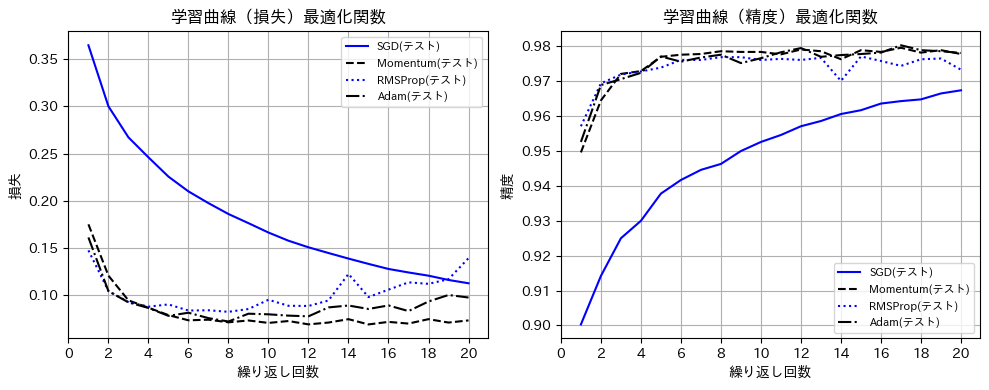

In [15]:
# 3つのhistoryを比較して描画
histories = [history1, history2, history3, history4]
plot_learning_curves_multi(
    histories,
    labels=["SGD", "Momentum", "RMSProp", "Adam"],
    title_suffix="最適化関数"
)


### バージョン確認

In [ ]:
!pip install watermark -qq
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
japanize_matplotlib: 1.1.3
torch              : 2.8.0+cu126
torchinfo          : 1.8.0
pandas             : 2.2.2
tqdm               : 4.67.1
numpy              : 2.0.2
torchvision        : 0.23.0+cu126
matplotlib         : 3.10.0

